In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 偏差和方差

In [2]:
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()
X

array([-15.93675813, -29.15297922,  36.18954863,  37.49218733,
       -48.05882945,  -8.94145794,  15.30779289, -34.70626581,
         1.38915437, -44.38375985,   7.01350208,  22.76274892])

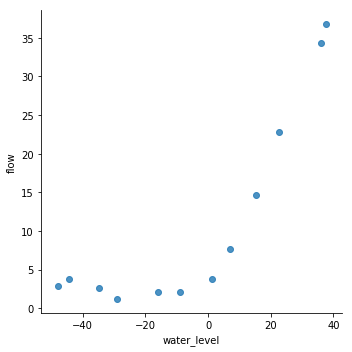

In [4]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=5)
plt.show()

In [5]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [9]:
X

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

## 代价函数

In [10]:
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [11]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

## 梯度

In [12]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [13]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

In [14]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [15]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

## 拟合数据
> 正则化项 $\lambda=0$

In [16]:
def linear_regression_np(X, y, l=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res

In [17]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [18]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')

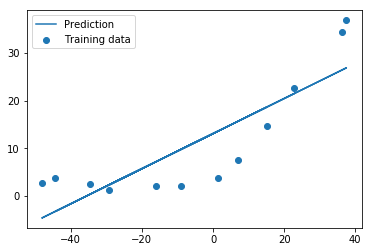

In [21]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=0)
plt.show()

In [22]:
training_cost, cv_cost = [], []

In [23]:
m = X.shape[0]
for i in range(1, m+1):
#     print('i={}'.format(i))
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
#     print('tc={}, cv={}'.format(tc, cv))
    
    training_cost.append(tc)
    cv_cost.append(cv)

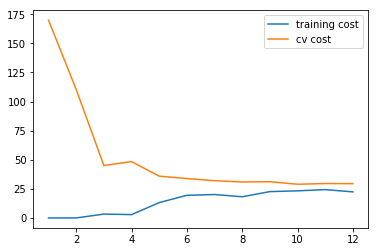

In [25]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=0)
plt.show()

## 多项式特征

In [29]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)

        # normalization
        ndarr = normalize_feature(df).as_matrix()

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [30]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [34]:
X, y, Xval, yval, Xtest, ytest = load_data()
X

array([-15.93675813, -29.15297922,  36.18954863,  37.49218733,
       -48.05882945,  -8.94145794,  15.30779289, -34.70626581,
         1.38915437, -44.38375985,   7.01350208,  22.76274892])

In [35]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


## 准备多项式回归数据
1. 扩展特征到 8阶,或者你需要的阶数
2. 使用 **归一化** 来合并 $x^n$ 
3. don't forget intercept term

In [36]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [37]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)

In [41]:
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

## 画出学习曲线
> 首先，我们没有使用正则化，所以 $\lambda=0$

In [42]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], l=l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

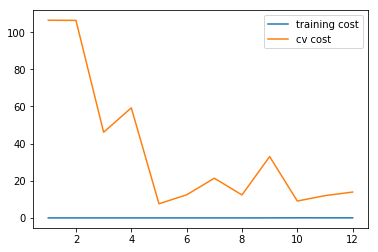

In [43]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

## try $\lambda=1$

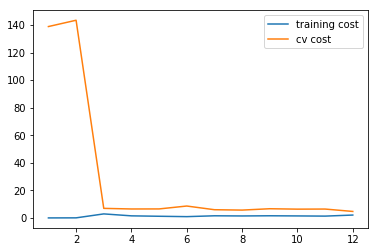

In [44]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

## try $\lambda=100$

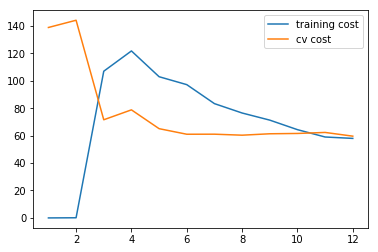

In [45]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

## 找到最佳的 $\lambda$

In [47]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [48]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

In [49]:
training_cost

[0.04336270422268315,
 0.11397641489623926,
 0.17165618057225407,
 0.22152798657326625,
 0.28185927650491194,
 0.45931783612623617,
 0.9217164418797217,
 2.076187189070741,
 4.901344330274262,
 16.09221729786736]

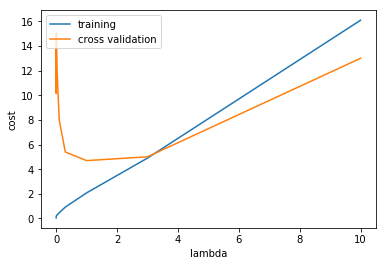

In [50]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [51]:
# best cv I got from all those candidates
l_candidate[np.argmin(cv_cost)]

1

In [52]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 9.982275423899827
test cost(l=0.001) = 10.96403493885111
test cost(l=0.003) = 11.264458872657682
test cost(l=0.01) = 10.880094765571297
test cost(l=0.03) = 10.022266931655883
test cost(l=0.1) = 8.632063139750382
test cost(l=0.3) = 7.336640278544401
test cost(l=1) = 7.466289435179381
test cost(l=3) = 11.64393193727906
test cost(l=10) = 27.715080291767972


调参后， $\lambda = 0.3$ 是最优选择，这个时候测试代价最小